# Origin Destination Dataset

This notebook presents an analysis of the origin destination datasets provided by the Sao Paulo government. The datasets contain information about how people move through the city in a tipycal workday, whether to go for work, school or to chill. Also, there are some socio-economic data regarding family income, gender, age and other information that we use to analyze the behaviour of people's trajectories.

## Datasets

We will be using the datasets from the Origin Destination census from 2017.

## Variables of Interest

The dataset contain dozens of variables, we focus our analysis in a small group to gather insights from the behaviour of the population. Here we give a brief description of those. Furthermore we start with a simple analysis on each one until we get to deeper insights about how people move in a typical day of the week.

 - **ZONA_O**: The origin;
 - **ZONA_D**: The destination zone;
 - **MODO_PRIN**: Main transport mode used in the trip;
 - **COORD_X_ORIGIN**: Latitude in the origin;
 - **COORD_Y_ORIGIN**: Longitude in the origin;
 - **COORD_X_DESTINATION**: Latitude in the destination;
 - **COORD_Y_DESTINATION**: Longitude in the destination;
 - **FEVIAG**: Expansion factor of the trajectory that represents how many more trips like that may exist.
 - **CD_ENTRE/ID_VIAG**: Binary flag to register if the interviewed person declared a trip. We want discard registers without trips.

In [2]:
# General Imports
import geopandas as gpd #pip install geopandas descartes
import pandas as pd #pip install pandas
import matplotlib.pyplot as plt # pip install matplotlib
import numpy as np

from multiprocessing import Pool
from dbfread import DBF #pip install dbfread
from simpledbf import Dbf5 #pip install simpledbf

# Loading the dataset

First we load the data from the 2017 dataset.

In [7]:
# a function to read the DBF file from a given dataset entry and return a Dataframe
# containing the N trips specified by chuncksize
def read_trips(dbf_file, chunksize=None):
    dbf = Dbf5(dbf_file)

    raw_trips = None
    
    if(chunksize == None):
        raw_trips = dbf.to_dataframe()
    else:
        raw_trips=[]
        trips_iterator = dbf.to_dataframe(chunksize=chunksize)
        
        for trip in trips_iterator:
            raw_trips.append(trip)
        
            break
    
        raw_trips = raw_trips[0]
 
    print('Scanned trips from:', dbf_file)
    return raw_trips

### Loading the datasets

We first read the datasets for the given year that we want analyse. We can load the entire dataset or just
a sample.

In [29]:
SAMPLE_SIZE = None
dbf_file = "../datasets/od2017/raw/Banco de dados/OD_2017.dbf"
trips2017 = read_trips(dbf_file, SAMPLE_SIZE)

len(trips2017)

Scanned trips from: ../datasets/od2017/raw/Banco de dados/OD_2017.dbf


183092

In [46]:
MODO_BIKE = 15
reduced_trips = trips2017[trips2017['MODOPRIN'] == MODO_BIKE].copy()

print("Number of records going by bike:", len(reduced_trips))
print("Number of people after expanding FE_VIA:", int(reduced_trips[["FE_VIA"]].sum()[0]))


Number of records going by bike: 1294
Number of people after expanding FE_VIA: 376975


In [47]:
### Step 2: Change coordinates projection to ellps:WGS84

# Create a dataframe containing origin coordinates CO_O_X and CO_O_Y
geo_trips_origins = gpd.GeoDataFrame(
    reduced_trips[['CO_O_X', 'CO_O_Y']], geometry=gpd.points_from_xy(reduced_trips.CO_O_X, reduced_trips.CO_O_Y))

# Convert origin coordinates to the desired projection 
geo_trips_origins.crs = {'init': 'epsg:22523'}
geo_trips_origins.to_crs({'proj': 'longlat', 'ellps': 'WGS84', 'no_defs': True}, inplace=True)

# Create a dataframe containing origin coordinates CO_D_X and CO_D_Y
geo_trips_destinations = gpd.GeoDataFrame(
    reduced_trips[['CO_D_X', 'CO_D_Y']], geometry=gpd.points_from_xy(reduced_trips.CO_D_X, reduced_trips.CO_D_Y))

# Convert destination coordinates to the desired projection
geo_trips_destinations.crs = {'init': 'epsg:22523'}
geo_trips_destinations.to_crs({'proj': 'longlat', 'ellps': 'WGS84', 'no_defs': True}, inplace=True)

None

/home/tallys/.local/lib/python3.8/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/tallys/.local/lib/python3.8/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [48]:
# Replace data by the new transformed coordinates
reduced_trips['CO_O_X'] = geo_trips_origins.apply(lambda x: x['geometry'].x, axis=1)
reduced_trips['CO_O_Y'] = geo_trips_origins.apply(lambda x: x['geometry'].y, axis=1)
reduced_trips['CO_D_X'] = geo_trips_destinations.apply(lambda x: x['geometry'].x, axis=1)
reduced_trips['CO_D_Y'] = geo_trips_destinations.apply(lambda x: x['geometry'].y, axis=1)

In [49]:
reduced_trips.to_csv('bike-trips.csv', index=False)

In [50]:
# A function to load points from the shapefile of a given entry
def read_zones(shapefile):
    # Read the shapefile pointed in the spec.json
    print("Reading shapefile: ", shapefile)
    zones_shape = gpd.read_file(shapefile, encoding='latin')
    print("Current projection: ", zones_shape.crs)

    # Projection used as Coordinate System, compatible with Cubu lat/lon format
    projection = {'proj': 'longlat', 'ellps': 'WGS84', 'no_defs': True}

    # Change projection for long/lat if different and save to new file
    if(zones_shape.crs != projection):
        print("Changing projection.")
        zones_shape = zones_shape.to_crs(projection)

    print('Scanned zones from:', shapefile, '\n')
    return zones_shape

Reading shapefile:  ../datasets/od2017/raw/Mapas/Shape/Zonas_2017_region.shp
Current projection:  {'init': 'epsg:22523'}
Changing projection.


/home/tallys/.local/lib/python3.8/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


Scanned zones from: ../datasets/od2017/raw/Mapas/Shape/Zonas_2017_region.shp 



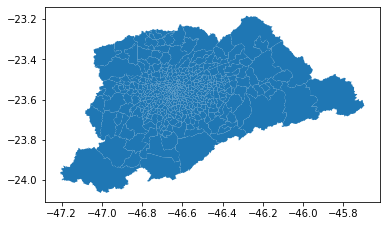

In [51]:
regions_map2017 = read_zones("../datasets/od2017/raw/Mapas/Shape/Zonas_2017_region.shp")
regions_map2017.plot()